# A notebook for empirical work on the `libData.csv` peer effects data

This cell sets up the notebook to import numpy, datetime, seaborn, pandas, matplotlib etc.

In [1]:
# Run this cell to set up the notebook.

# These lines import the Numpy, Pandas, Datetime, Seaborn, Matplotlib, Scipy.Stats, etc.
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import datetime as datetime
import random
import matplotlib
import matplotlib.pyplot as plt

# Importing plotting libraries and styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# For Pandas to ignore FutureWarning displays
import warnings
warnings.simplefilter('ignore', FutureWarning)

## Summary Statistics

The function below computes summary statistics.

**Format:** ID, Person, Table, Library, Arrival Time, Departure Time, Num Breaks, Break Start Times (list), Break End Times (list), fromStart, tillEnd, Neighbors, Known, yourName, yourTable, yourSeat

* Average duration of stay (percentiles as well) DONE
* Average number of breaks DONE
* Average duration of break DONE
* Average work-time between breaks (frequency of breaks) todo: compute on paper DONE
* Average number of neighbors DONE
* Number of people per library DONE
* Number of people there fromStart DONE
* Number of people there tillEnd DONE

In [2]:
libData = pd.read_csv('libDataTest.csv')
libData

,ID,Person,Table,Library,Arrival,Departure,Num_Breaks,Break_Start,Break_End,fromStart,tillEnd,Neighbors,Known,yourName,yourTable,yourSeat
0,5657,2,A,Moffit,2019-03-23 18:20:02.703347,2019-03-23 18:33:47.097748,0,[],[],0,0,"[(5, 7808)]",[],Max,B,2
1,7808,5,A,Moffit,2019-03-23 18:20:02.705239,2019-03-23 18:42:29.331629,1,"[datetime.datetime(2019, 3, 23, 18, 20, 3, 781...","[datetime.datetime(2019, 3, 23, 18, 30, 23, 76...",0,1,"[(2, 5657)]",[],Max,B,2
2,7657,1,B,Stacks,2019-03-23 18:25:41.342617,2019-03-23 18:37:07.846707,1,"[datetime.datetime(2019, 3, 23, 18, 27, 36, 35...","[datetime.datetime(2019, 3, 23, 18, 37, 7, 846...",1,0,"[(3, 7477), (6, 6146)]","[(3, 7477), (6, 6146)]",Max,B,2
3,7477,3,B,Stacks,2019-03-23 18:27:35.896722,2019-03-23 18:42:29.331629,2,"[datetime.datetime(2019, 3, 23, 18, 27, 36, 35...","[datetime.datetime(2019, 3, 23, 18, 37, 7, 846...",0,1,"[(1, 7657), (6, 6146)]","[(1, 7657)]",Max,B,2
4,6146,6,B,Stacks,2019-03-23 18:34:10.473014,2019-03-23 18:42:29.331629,0,[],[],0,1,"[(1, 7657), (3, 7477)]","[(1, 7657)]",Max,B,2


In [3]:
# This function takes in the libData.csv dataframe and outputs some summary statistics about the data.

def summaryStats(libData):
    libStats = pd.DataFrame()
    departureDatetime = libData["Departure"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    arrivalDatetime = libData["Arrival"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    duration = (departureDatetime - arrivalDatetime).apply(datetime.timedelta.total_seconds)
    libStats['duration'] = duration
    libStats['num_breaks'] = libData["Num_Breaks"]
    libStats['fromStart'] = libData["fromStart"]
    libStats['tillEnd'] = libData["tillEnd"]
    libStats['num_neighbors'] = libData["Neighbors"].apply(eval).apply(len)
    libStats['known'] = libData["Known"].apply(eval).apply(len)
    
    # Maximum number of breaks for each person
    maxBreaks = libData["Break_End"].apply(lambda x: eval(x)).apply(len)
    breakEnds = libData["Break_End"].apply(lambda x: eval(x))
    breakStarts = libData["Break_Start"].apply(lambda x: eval(x))
    
    # Array of average durations for each row which will be appended into libStats
    breakDurationArray = []
    
    for rowIndex in range(len(libData)):
        avgDuration = []
        for breakIndex in range(maxBreaks[rowIndex]):
            breakDuration = breakEnds[rowIndex][breakIndex] - breakStarts[rowIndex][breakIndex]
            avgDuration.append(breakDuration.total_seconds())
        breakDurationArray.append(np.mean(avgDuration))
    
    libStats['average_break_duration'] = breakDurationArray
    
    # Computing average duration between break
    betweenBreakDuration = []
    # Required array of start breaks
    maxStartBreaks = libData["Break_Start"].apply(lambda x: eval(x)).apply(len)
    
    for rowIndex in range(len(libData)):
        avgBetweenDuration = []
        
        # Including the time from arrival to breakStart
        if len(breakStarts[rowIndex])>0:
            avgBetweenDuration.append((breakStarts[rowIndex][0] - arrivalDatetime[rowIndex]).total_seconds())
        
        for j in range(1, maxStartBreaks[rowIndex]):
            # Adding the difference between new breakStart time and old breakEnd time
            avgBetweenDuration.append((breakStarts[rowIndex][j] - breakEnds[rowIndex][j-1]).total_seconds())
            
        betweenBreakDuration.append(np.mean(avgBetweenDuration))
    
    libStats['time_between_breaks'] = betweenBreakDuration
    
    print("Number of people who were there at the start:", np.count_nonzero(libData["fromStart"]))
    print("Number of people who stayed till the end:", np.count_nonzero(libData["tillEnd"]))
    peoplePerLibrary = libData.groupby("Library").count()["Person"]
    
    for i in peoplePerLibrary.index:
        print("Number of people in "+ i + " is: " + str(peoplePerLibrary[i]))
    
    return libStats.describe()

In [4]:
summaryStats(libData)

Number of people who were there at the start: 1
Number of people who stayed till the end: 3
Number of people in Moffit is: 2
Number of people in Stacks is: 3


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,duration,num_breaks,fromStart,tillEnd,num_neighbors,known,average_break_duration,time_between_breaks
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,3.000000,3.000000
mean,849.963681,0.80000,0.200000,0.600000,1.600000,0.80000,540.731824,111.198526
std,315.915807,0.83666,0.447214,0.547723,0.547723,0.83666,98.322381,93.339332
min,498.858615,0.00000,0.000000,0.000000,1.000000,0.00000,430.707386,16.010014
25%,686.504090,0.00000,0.000000,0.000000,1.000000,0.00000,501.098699,65.511952
50%,824.394401,1.00000,0.000000,1.000000,2.000000,1.00000,571.490012,115.013889
75%,893.434907,1.00000,0.000000,1.000000,2.000000,1.00000,595.744042,158.792781
max,1346.626390,2.00000,1.000000,1.000000,2.000000,2.00000,619.998073,202.571674


In [5]:
libData

,ID,Person,Table,Library,Arrival,Departure,Num_Breaks,Break_Start,Break_End,fromStart,tillEnd,Neighbors,Known,yourName,yourTable,yourSeat
0,5657,2,A,Moffit,2019-03-23 18:20:02.703347,2019-03-23 18:33:47.097748,0,[],[],0,0,"[(5, 7808)]",[],Max,B,2
1,7808,5,A,Moffit,2019-03-23 18:20:02.705239,2019-03-23 18:42:29.331629,1,"[datetime.datetime(2019, 3, 23, 18, 20, 3, 781...","[datetime.datetime(2019, 3, 23, 18, 30, 23, 76...",0,1,"[(2, 5657)]",[],Max,B,2
2,7657,1,B,Stacks,2019-03-23 18:25:41.342617,2019-03-23 18:37:07.846707,1,"[datetime.datetime(2019, 3, 23, 18, 27, 36, 35...","[datetime.datetime(2019, 3, 23, 18, 37, 7, 846...",1,0,"[(3, 7477), (6, 6146)]","[(3, 7477), (6, 6146)]",Max,B,2
3,7477,3,B,Stacks,2019-03-23 18:27:35.896722,2019-03-23 18:42:29.331629,2,"[datetime.datetime(2019, 3, 23, 18, 27, 36, 35...","[datetime.datetime(2019, 3, 23, 18, 37, 7, 846...",0,1,"[(1, 7657), (6, 6146)]","[(1, 7657)]",Max,B,2
4,6146,6,B,Stacks,2019-03-23 18:34:10.473014,2019-03-23 18:42:29.331629,0,[],[],0,1,"[(1, 7657), (3, 7477)]","[(1, 7657)]",Max,B,2


## Simulated pairs vs actual pairs hypothesis test - confidence interval

In [6]:
def bootStrap(database, statistic_fn, num_repetitions, model=False, startTime=None, endTime=None, libraryName=None):
    """ A function to perform the bootstrap of libData and compute a distribution based on actual, sampled pairs.
    
    libData: Our library_data dataframe loaded in Pandas
    statistic_fn: The test_statistic that we want to compute: eg. difference in leaving times of two pairs
    num_repetitions: The number of repetitions that you want to compute the bootstrap
    
    Note: startTime, endTime, libraryName filtering not implemented yet.
    """
    idSeries = database['ID']
    tableSeries = database['Table']
    #libName = database['Library']
    if model:
        neighbourSeries = database["Neighbors"]
    else:
        neighbourSeries = database["Neighbors"].apply(lambda x: eval(x))
    
    actual_pairs = []
    
    for i in np.arange(len(idSeries)):
        for tpl in neighbourSeries[i]:
            # Add sorted tuples only to the set
            sortedTpl = tuple(sorted((idSeries[i], tpl[1])))
            if sortedTpl not in actual_pairs:
                actual_pairs.append(sortedTpl)
        
    n = len(actual_pairs)
    
    # Observed value of the test statistic
    actual_avg_difference = statistic_fn(actual_pairs, database, model)
    
    # Array to store the test statistics
    test_stats = np.array([])
    
    # random.sample(idSeries, n) is without_replacement
    # random.choice(idSeries) is with_replacement
    for i in np.arange(num_repetitions):
        print(i)
        # Draw 2 people without replacement n times
        sampled_pairs = [tuple(random.sample(list(idSeries), 2)) for _ in range(n)]
        #z1 = [random.choice(idSeries) for _ in range(n)]
        #z2 = [random.choice(idSeries) for _ in range(n)]
        #sampled_pairs = list(zip(z1, z2))
        

        # For each pair, calculate some statistic such as difference in leaving times 
        sampled_avg_difference = statistic_fn(sampled_pairs, database, model)
        
        # Append this back to test_stats
        test_stats = np.append(test_stats, sampled_avg_difference)
    
    # 95% confidence interval
    left = np.percentile(test_stats, 2.5)
    right = np.percentile(test_stats, 97.5)
    print("95% Confidence Interval is", (left, right))
    print("Observed value (in actual pairs) is", actual_avg_difference)
    
    plt.hist(test_stats)
    plt.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1)
    
    # Observed value statistic on actual_pairs
    plt.scatter(actual_avg_difference, 0, color='red', s=30, zorder=2)
    
    return

In [7]:
def difference_in_leaving_times(pairs, tbl, model):
    if model:
        departureDatetime = tbl["Departure"]
    else:
        departureDatetime = tbl["Departure"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    
    differences = []
    for tpl in pairs:
        # Finding index in dataframe based on ID
        leaving_time_0_index = tbl[tbl["ID"]==tpl[0]].index[0]
        leaving_time_1_index = tbl[tbl["ID"]==tpl[1]].index[0]
        # Finding the difference in leaving times
        time_diff = departureDatetime[leaving_time_0_index] - departureDatetime[leaving_time_1_index]
        differences.append(abs(time_diff.total_seconds()))
    
    return np.mean(differences)

In [8]:
def difference_in_arrival_times(pairs, tbl, model):
    if model:
        arrivalDatetime = tbl["Arrival"]
    else:
        arrivalDatetime = tbl["Arrival"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    
    differences = []
    for tpl in pairs:
        # Finding index in dataframe based on ID
        arrival_time_0_index = tbl[tbl["ID"]==tpl[0]].index[0]
        arrival_time_1_index = tbl[tbl["ID"]==tpl[1]].index[0]
        # Finding the difference in arrival times
        time_diff = arrivalDatetime[arrival_time_0_index] - arrivalDatetime[arrival_time_1_index]
        differences.append(abs(time_diff.total_seconds()))
        
    return np.mean(differences)

In [9]:
def difference_in_num_breaks(pairs, tbl, model):
    numBreaks = tbl["Num_Breaks"]
    
    differences = []
    
    for tpl in pairs:
        # Finding index in dataframe based on ID
        break_0_index = tbl[tbl["ID"]==tpl[0]].index[0]
        break_1_index = tbl[tbl["ID"]==tpl[1]].index[0]
        # Finding the difference in number of breaks
        n_diff = numBreaks[break_0_index] - numBreaks[break_1_index]
        differences.append(abs(n_diff))
    
    return np.mean(differences)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

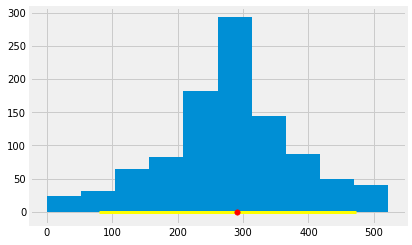

In [10]:
bootStrap(libData, difference_in_leaving_times, 1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

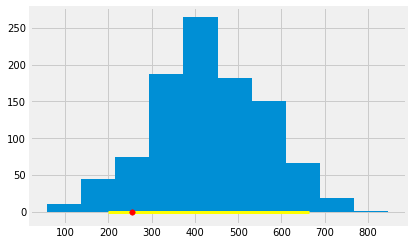

In [11]:
bootStrap(libData, difference_in_arrival_times, 1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

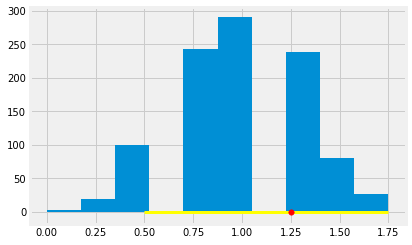

In [12]:
bootStrap(libData, difference_in_num_breaks, 1000)

## Model of test

In [110]:
319%8

7

In [ ]:
def generateModelData():
    # Using 01/01/2019 7 pm as our starting date
    simLibData = pd.DataFrame()
    startTime = datetime.datetime.strptime("01/01/19 19:00", "%d/%m/%y %H:%M")
    
    # Arrival time modeled as Uniform(0, 120)
    arrival_times_delta = stats.uniform.rvs(0,120,200)
    convertToTimeDelta = np.array([datetime.timedelta(minutes = x) for x in arrival_times_delta])
    
    arrival_times = startTime + convertToTimeDelta
    
    # 40 tables
    #dictionaryKeys = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + \
    #                "A1 B1 C1 D1 E1 F1 G1 H1 I1 J1 K1 L1 M1 N1".split(" ")
    #dictionaryValues = [[1, 2, 3, 4, 5, 6, 7, 8] for i in range(40)]
    #tableDict = dict(zip(dictionaryKeys, dictionaryValues))
    
    # Creating table array for all 200 people
    table_list = np.random.choice(list(dictionaryKeys)*8, 200, replace=False)
    seat_list = []
    
    # Creating seat array for all 200 people
    for table in table_list:
        item = np.random.choice(tableDict[table])
        tableDict[table].remove(item)
        seat_list.append(item)
    
    #simLibData['Table'] = table_list
    #simLibData['Person'] = seat_list    

    # Length of stay modelled as Normal(60, 15)
    duration = stats.norm.rvs(60, 15, 200)
    duration_in_timeDelta = np.array([datetime.timedelta(minutes = x) for x in duration])
    departure_times = arrival_times + duration_in_timeDelta
    person_table = table_list
    person_seat = seat_list
    
    # Tuple of (Arrival_Time, Duration, DP)
    departure_duration_tpl = [(arrival_times[i], duration[i], departure_times[i], person_table[i], person_seat[i]) \
                              for i in range(len(departure_times))]
    
    # Sorting the (departure_time, duration) array by departure time
    sorted_departures = sorted(departure_duration_tpl, key=lambda x: x[2])
    
    # Adding duration and departure back to the main table
    simLibData["Arrival"] = np.asarray([tpl[0] for tpl in sorted_departures])
    simLibData['Duration'] = np.asarray([tpl[1] for tpl in sorted_departures])
    simLibData['Tentative Departure'] = np.asarray([tpl[2] for tpl in sorted_departures])
    simLibData['Table'] = np.asarray([tpl[3] for tpl in sorted_departures])
    simLibData["Person"] = np.asarray([tpl[4] for tpl in sorted_departures])
    
    # Giving each row/person a unique ID (from 0 to 199)
    simLibData = simLibData.reset_index()
    simLibData.rename(columns={'index':'ID'}, inplace=True)
    
    # Simulating our model, going through all the rows
    p_arrival_times = simLibData['Arrival'].copy(deep=True)
    peer_departure_times = simLibData['Tentative Departure'].copy(deep=True)
    peer_durations = simLibData['Duration'].copy(deep=True)
    peer_effect_indicators = np.asarray([0 for i in range(len(peer_durations))])
    present_neighbors = [ [] for i in range(len(peer_durations)) ]
    
    # Q
    num_changed_this_iteration = 1
    
    while num_changed_this_iteration > 0:
        num_changed_this_iteration = 0
        
        for i, personRow in simLibData.iterrows():
            tableName = personRow["Table"]
            filtered_DF = simLibData[simLibData["Table"]==tableName]
            personDeparture = peer_departure_times[i]

            for j, filterRow in filtered_DF.iterrows():
                if (p_arrival_times[j] < personDeparture) and (peer_departure_times[j] > personDeparture):
                    neighborName = filterRow["Person"]
                    exists = False
                    for tpl in present_neighbors[i]:
                        # If ID already exists in the neighbors array
                        if (tpl[1]==j):
                            exists = True
                            break
                    if not exists:
                        present_neighbors[i].append((neighborName, j))
                    if (peer_effect_indicators[i] == 0):
                        peer_durations[i] = 1.1 * peer_durations[i]
                        peer_departure_times[i] = p_arrival_times[i] + datetime.timedelta(minutes = peer_durations[i])
                        peer_effect_indicators[i] = 1
                        num_changed_this_iteration = num_changed_this_iteration + 1
    
    simLibData["Departure"] = peer_departure_times
    simLibData["Duration"] = peer_durations
    simLibData["Indicator"] = peer_effect_indicators
    simLibData["Neighbors"] = present_neighbors
    
    return simLibData

In [267]:
def generateModelData2():
    # Using 01/01/2019 7 pm as our starting date
    simLibData = pd.DataFrame()
    startTime = datetime.datetime.strptime("01/01/19 19:00", "%d/%m/%y %H:%M")
    
    # Arrival time modeled as Uniform(0, 120)
    arrival_times_delta = stats.uniform.rvs(0,120,200)
    convertToTimeDelta = np.array([datetime.timedelta(minutes = x) for x in arrival_times_delta])
    
    arrival_times = startTime + convertToTimeDelta
    
    # 40 tables
    dictionaryKeys = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + \
                    "A1 B1 C1 D1 E1 F1 G1 H1 I1 J1 K1 L1 M1 N1".split(" ")
    dictionaryValues = [[1, 2, 3, 4, 5, 6, 7, 8] for i in range(40)]
    tableDict = dict(zip(dictionaryKeys, dictionaryValues))
    
    # Creating table array for all 200 people
    table_list = np.random.choice(list(dictionaryKeys)*8, 200, replace=False)
    seat_list = []
    
    # Creating seat array for all 200 people
    for table in table_list:
        item = np.random.choice(tableDict[table])
        tableDict[table].remove(item)
        seat_list.append(item)
    
    simLibData["Arrival"] = np.sort(arrival_times)
    simLibData['Table'] = table_list
    simLibData['Person'] = seat_list    

    # Length of stay modelled as Normal(60, 15)
    duration = stats.norm.rvs(60, 15, 200)
    duration_in_timeDelta = np.array([datetime.timedelta(minutes = x) for x in duration])
    departure_times = np.sort(arrival_times) + duration_in_timeDelta
    simLibData['Duration'] = duration
    simLibData['Tentative Departure'] = departure_times
    
    # Sorting the (departure_time, duration) array by departure time
    simLibData = simLibData.sort_values("Tentative Departure")
    
    # Giving each row/person a unique ID (from 0 to 199)
    simLibData = simLibData.reset_index()
    simLibData.rename(columns={'index':'ID'}, inplace=True)
    
    # Simulating our model, going through all the rows
    p_arrival_times = simLibData['Arrival'].copy(deep=True)
    peer_departure_times = simLibData['Tentative Departure'].copy(deep=True)
    peer_durations = simLibData['Duration'].copy(deep=True)
    peer_effect_indicators = np.asarray([0 for i in range(len(peer_durations))])
    present_neighbors = [ [] for i in range(len(peer_durations)) ]
    
    # Q
    num_changed_this_iteration = 1
    
    while num_changed_this_iteration > 0:
        num_changed_this_iteration = 0
        
        for i, personRow in simLibData.iterrows():
            tableName = personRow["Table"]
            filtered_DF = simLibData[simLibData["Table"]==tableName]
            personDeparture = peer_departure_times[i]

            for j, filterRow in filtered_DF.iterrows():
                if (p_arrival_times[j] < personDeparture) and (peer_departure_times[j] > personDeparture) and j!=i:
                    neighborName = filterRow["Person"]
                    exists = False
                    for tpl in present_neighbors[i]:
                        # If ID already exists in the neighbors array
                        if (tpl[1]==j):
                            exists = True
                            break
                    if not exists:
                        present_neighbors[i].append((neighborName, j))
                    if (peer_effect_indicators[i] == 0):
                        peer_durations[i] = 1.1 * peer_durations[i]
                        peer_departure_times[i] = p_arrival_times[i] + datetime.timedelta(minutes = peer_durations[i])
                        peer_effect_indicators[i] = 1
                        num_changed_this_iteration = num_changed_this_iteration + 1
    
    simLibData["Departure"] = peer_departure_times
    simLibData["Duration"] = peer_durations
    simLibData["Indicator"] = peer_effect_indicators
    simLibData["Neighbors"] = present_neighbors
    
    
    return simLibData

In [268]:
# This function takes in the libData.csv dataframe and outputs some summary statistics about the data.

def modelSummaryStats(libData):
    libStats = pd.DataFrame()
    libStats['Departure Time'] = libData["Departure"]
    libStats['Arrival Time'] = libData["Arrival"]
    duration = libData["Duration"]
    libStats['duration'] = duration
    libStats["Indicator"] = libData["Indicator"] 
    libStats['num_neighbors'] = libData["Neighbors"].apply(len)
    return libStats.describe()

In [269]:
modelData = generateModelData2()

In [270]:
modelData.head(20)

,ID,Arrival,Table,Person,Duration,Tentative Departure,Departure,Indicator,Neighbors
0,1,2019-01-01 19:00:46.102546,C1,8,41.227962,2019-01-01 19:38:14.900467,2019-01-01 19:41:59.780259,1,"[(3, 28), (1, 31)]"
1,8,2019-01-01 19:04:24.896688,F,5,43.094622,2019-01-01 19:43:35.512450,2019-01-01 19:47:30.574026,1,"[(3, 19), (6, 48), (7, 51), (4, 101)]"
2,6,2019-01-01 19:02:19.192165,D1,1,44.422295,2019-01-01 19:46:44.529869,2019-01-01 19:46:44.529869,0,[]
3,20,2019-01-01 19:09:32.691492,I1,4,42.044833,2019-01-01 19:47:46.046008,2019-01-01 19:51:35.381460,1,"[(6, 49)]"
4,21,2019-01-01 19:10:53.731081,F1,8,45.003854,2019-01-01 19:51:48.486751,2019-01-01 19:55:53.962318,1,"[(4, 61)]"
5,2,2019-01-01 19:01:18.622404,I,3,51.948340,2019-01-01 19:53:15.522778,2019-01-01 19:53:15.522778,0,[]
6,26,2019-01-01 19:15:30.984624,Z,1,42.384716,2019-01-01 19:54:02.878203,2019-01-01 19:57:54.067561,1,"[(2, 108)]"
7,0,2019-01-01 19:00:41.342173,U,4,59.788715,2019-01-01 19:55:02.544790,2019-01-01 20:00:28.665051,1,"[(3, 22)]"
8,32,2019-01-01 19:19:08.659104,N,5,41.390452,2019-01-01 19:56:46.320130,2019-01-01 20:00:32.086232,1,"[(7, 90)]"
9,4,2019-01-01 19:01:36.255755,H,1,60.924331,2019-01-01 19:56:59.401080,2019-01-01 20:02:31.715613,1,"[(7, 36), (5, 71)]"


In [271]:
len(modelData[modelData["Indicator"]==0])

34

In [272]:
modelData[modelData["Table"]=="E1"]

,ID,Arrival,Table,Person,Duration,Tentative Departure,Departure,Indicator,Neighbors
27,38,2019-01-01 19:25:16.433051,E1,1,57.142800,2019-01-01 20:17:13.313077,2019-01-01 20:22:25.001080,1,"[(2, 114)]"
114,110,2019-01-01 20:05:26.146531,E1,2,68.894090,2019-01-01 21:08:04.005996,2019-01-01 21:14:19.791942,1,"[(7, 117), (4, 152), (5, 155), (3, 171)]"
117,183,2019-01-01 20:44:32.992963,E1,7,28.981873,2019-01-01 21:10:53.822378,2019-01-01 21:13:31.905320,1,"[(2, 114), (4, 152), (5, 155), (3, 171)]"
152,162,2019-01-01 20:33:05.341253,E1,4,61.337711,2019-01-01 21:28:51.034601,2019-01-01 21:34:25.603936,1,"[(5, 155), (3, 171)]"
155,152,2019-01-01 20:26:24.137373,E1,5,70.882923,2019-01-01 21:30:50.478607,2019-01-01 21:37:17.112730,1,"[(4, 152), (3, 171)]"
171,159,2019-01-01 20:30:30.439726,E1,3,72.860561,2019-01-01 21:43:22.073358,2019-01-01 21:43:22.073358,0,[]


### Summary Stats for Model Database

In [273]:
modelSummaryStats(modelData)

,duration,Indicator,num_neighbors
count,200.000000,200.000000,200.000000
mean,67.588261,0.830000,1.940000
std,15.183261,0.376575,1.376909
min,25.773527,0.000000,0.000000
25%,57.028486,1.000000,1.000000
50%,69.145949,1.000000,2.000000
75%,77.839541,1.000000,3.000000
max,102.555115,1.000000,5.000000


### Bootstrapping the Model Database

modelData = modelData.reset_index()
modelData = modelData.drop("ID", axis = 1)
modelData.rename(columns={'index':'ID'}, inplace=True)
modelData

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
95% Confidence Interval is (2143.9451227641475, 2470.845796100517)
Observed value (in actual pairs) is 1790.3699817493539


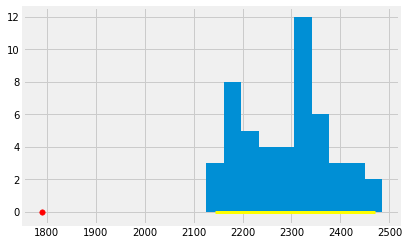

In [274]:
bootStrap(modelData, difference_in_arrival_times, 50, model=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
95% Confidence Interval is (2231.298517280833, 2596.674546293561)
Observed value (in actual pairs) is 1823.7924867727272


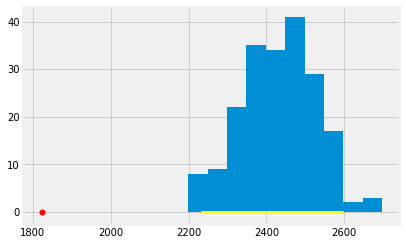

In [238]:
bootStrap(modelData, difference_in_leaving_times, 200, model=True)

In [436]:
modelData.to_csv("modelData1.csv")

In [87]:
dictionaryKeys = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + \
                    "A1 B1 C1 D1 E1 F1 G1 H1 I1 J1 K1 L1 M1 N1".split(" ")
dictionaryValues = [[1, 2, 3, 4, 5, 6, 7, 8] for i in range(40)]
tableDict = dict(zip(dictionaryKeys, dictionaryValues))

# Creating table array for all 200 people
table_list = np.random.choice(list(dictionaryKeys)*8, 200, replace=False)
seat_list = []

# Creating seat array for all 200 people
for table in table_list:
    item = np.random.choice(tableDict[table])
    tableDict[table].remove(item)
    seat_list.append(item)

In [91]:
[(table_list[i], seat_list[i]) for i in range(len(table_list))]

[('E', 6),
 ('V', 5),
 ('L1', 5),
 ('I', 6),
 ('A', 2),
 ('H1', 6),
 ('R', 3),
 ('S', 8),
 ('T', 4),
 ('P', 4),
 ('Q', 5),
 ('Z', 8),
 ('I', 7),
 ('N', 8),
 ('K1', 6),
 ('B', 5),
 ('G1', 7),
 ('B1', 3),
 ('K1', 2),
 ('F1', 8),
 ('P', 6),
 ('L1', 7),
 ('H', 8),
 ('W', 6),
 ('X', 5),
 ('H1', 4),
 ('V', 2),
 ('G', 2),
 ('J', 5),
 ('G', 3),
 ('J1', 8),
 ('K1', 4),
 ('N1', 3),
 ('F', 6),
 ('G', 5),
 ('N', 7),
 ('E1', 6),
 ('M1', 2),
 ('S', 4),
 ('G1', 5),
 ('C1', 5),
 ('V', 6),
 ('C', 8),
 ('O', 8),
 ('M', 5),
 ('X', 2),
 ('L', 6),
 ('T', 7),
 ('S', 1),
 ('O', 6),
 ('D1', 6),
 ('X', 7),
 ('U', 1),
 ('U', 4),
 ('I1', 1),
 ('L', 1),
 ('J1', 3),
 ('L1', 8),
 ('K1', 3),
 ('I1', 6),
 ('N1', 1),
 ('N1', 2),
 ('B1', 1),
 ('H1', 1),
 ('W', 4),
 ('M1', 6),
 ('M', 3),
 ('Q', 2),
 ('H', 4),
 ('I1', 7),
 ('X', 8),
 ('F1', 6),
 ('D1', 5),
 ('X', 6),
 ('E', 4),
 ('D', 1),
 ('B', 1),
 ('W', 5),
 ('R', 6),
 ('N1', 8),
 ('J1', 4),
 ('Z', 6),
 ('A1', 2),
 ('Z', 4),
 ('E1', 8),
 ('A1', 4),
 ('B', 8),
 ('F1', 